In [202]:
import numpy as np
import pandas as pd
import shutil, time, os, requests, random, copy
from itertools import permutations 
import seaborn as sns
import imageio
from skimage.transform import rotate, AffineTransform, warp, resize
#import skvideo.io as vidio
#from google.colab.patches import cv2_imshow
from IPython.display import clear_output, Image, SVG
import h5py
#from tabulate import tabulate

import torch
import torch.nn as nn
import torch.nn.functional as tF
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import torchvision.datasets as dset
from torchvision import datasets, transforms, models
from torchvision.transforms import ToTensor
#from torchviz import make_dot
#from torchsummary import summary

from sklearn.utils import shuffle
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc, f1_score
from sklearn.metrics import average_precision_score, precision_recall_curve, roc_auc_score, accuracy_score
from sklearn.utils.class_weight import compute_class_weight
from sklearn.model_selection import train_test_split

import matplotlib.pyplot as plt
#import matplotlib.animation as animation
%matplotlib inline
from typing import Type, Any, Callable, Union, List, Optional
from torch import Tensor
from collections import OrderedDict 

from sklearn.manifold import TSNE


In [203]:
torch.manual_seed(0)

In [204]:
# set device
if torch.cuda.is_available():
    print('Using GPU')
    device = torch.device('cuda')
else:
    print('Using CPU')
    device = torch.device('cpu')

Using GPU


In [205]:
# Settings
settings = {
    'batch_size': 256,
    'epochs': 10,
    'learning_rate': 0.001,
}

In [206]:
# DataLoader
train_set = datasets.CIFAR10(
    root="data",
    train=True,
    download=True,
    transform=ToTensor(),
)

test_set = datasets.CIFAR10(
    root="data",
    train=False,
    download=True,
    transform=ToTensor(),
)

train_batch = DataLoader(train_set, batch_size=settings['batch_size'], shuffle=False)
test_batch = DataLoader(test_set, batch_size=settings['batch_size'], shuffle=False)


Files already downloaded and verified
Files already downloaded and verified


In [207]:
images = train_batch.dataset.data
labels = train_batch.dataset.targets
test_images = test_batch.dataset.data
test_labels = test_batch.dataset.targets

print(images.shape, test_images.shape)


(50000, 32, 32, 3) (10000, 32, 32, 3)


In [208]:
trimages = train_batch.dataset.data
tsimages = test_batch.dataset.data

In [209]:
labels = np.int_(labels)
test_labels = np.int_(test_labels)

In [210]:
lab_dict = {0:'airplane',1:'automobile',2:'bird',3:'cat',4:'deer',5:'dog',6:'frog',7:'horse',8:'ship',9:'truck'}

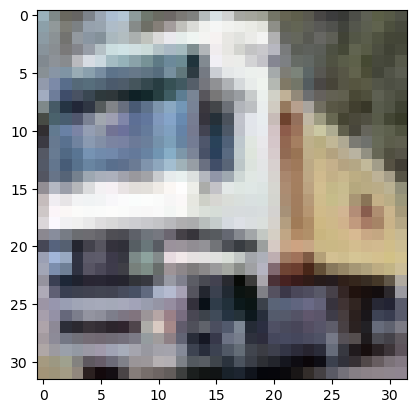

truck


In [211]:
plt.imshow(train_batch.dataset.data[1]/255.0)
plt.show()
print(lab_dict[labels[1]])

In [212]:
class Cutout(nn.Module):
    def __init__(self, seed = 0):
        self.seed = seed
        
    def get_start_index(self,L):
        return np.random.randint(L)
    
    def __call__(self,frame):
        channels, h, w = frame.shape
        #print(frames.shape)
        size = h//4
        n_squares = np.random.randint(1,3,1)[0]
        new_image = frame
        for _ in range(n_squares):
            y = np.clip(self.get_start_index(h), size // 2, h - size//2)
            x = np.clip(self.get_start_index(w), size // 2, w - size//2)
            
            y1 = np.clip(y - size // 2, 0, h)
            y2 = np.clip(y + size // 2, 0, h)
            x1 = np.clip(x - size // 2, 0, w)
            x2 = np.clip(x + size // 2, 0, w)
            new_image[:, y1:y2,x1:x2] = 0
        return new_image

In [213]:
class AddGaussianNoise(nn.Module):
    def __init__(self, mean=0., std=1.):
        self.std = std
        self.mean = mean
        
    def __call__(self, tensor):
        return tensor + torch.randn(tensor.size()) * self.std + self.mean
    
    def __repr__(self):
        return self.__class__.__name__ + '(mean={0}, std={1})'.format(self.mean, self.std)

In [214]:
images = images.transpose(0,3,1,2)

MEAN = np.mean(images[:40000]/255.0,axis=(0,2,3),keepdims=True)
STD = np.std(images[:40000]/255.0,axis=(0,2,3),keepdims=True)

In [215]:
class C10DataGen(Dataset):
    def __init__(self,phase,imgarr,s = 0.5):
        self.phase = phase
        self.imgarr = imgarr
        self.s = s
        self.transforms = transforms.Compose([transforms.RandomHorizontalFlip(0.5),
                                              transforms.RandomResizedCrop(32,(0.8,1.0)),
                                              transforms.Compose([transforms.RandomApply([transforms.ColorJitter(0.8*self.s, 
                                                                                                                 0.8*self.s, 
                                                                                                                 0.8*self.s, 
                                                                                                                 0.2*self.s)], p = 0.8),
                                                                  transforms.RandomGrayscale(p=0.2)
                                                                 ])])

    def __len__(self):
        return self.imgarr.shape[0]

    def __getitem__(self,idx):
        
        x = self.imgarr[idx] 
        #print(x.shape)
        x = x.astype(np.float32)/255.0

        x1 = self.augment(torch.from_numpy(x))
        x2 = self.augment(torch.from_numpy(x))
        
        x1 = self.preprocess(x1)
        x2 = self.preprocess(x2)
        
        return x1, x2

    #shuffles the dataset at the end of each epoch
    def on_epoch_end(self):
        self.imgarr = self.imgarr[random.sample(population = list(range(self.__len__())),k = self.__len__())]

    def preprocess(self,frame):
        frame = (frame-MEAN)/STD
        return frame
    
    #applies randomly selected augmentations to each clip (same for each frame in the clip)
    def augment(self, frame, transformations = None):
        
        if self.phase == 'train':
            frame = self.transforms(frame)
        else:
            return frame
        
        return frame

In [216]:
dg = C10DataGen('train',images) #train_df)
print(images.shape)
dl = DataLoader(dg,batch_size = 256)

(50000, 3, 32, 32)


e:\Anaconda\envs\snk\lib\site-packages\torchvision\transforms\functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(


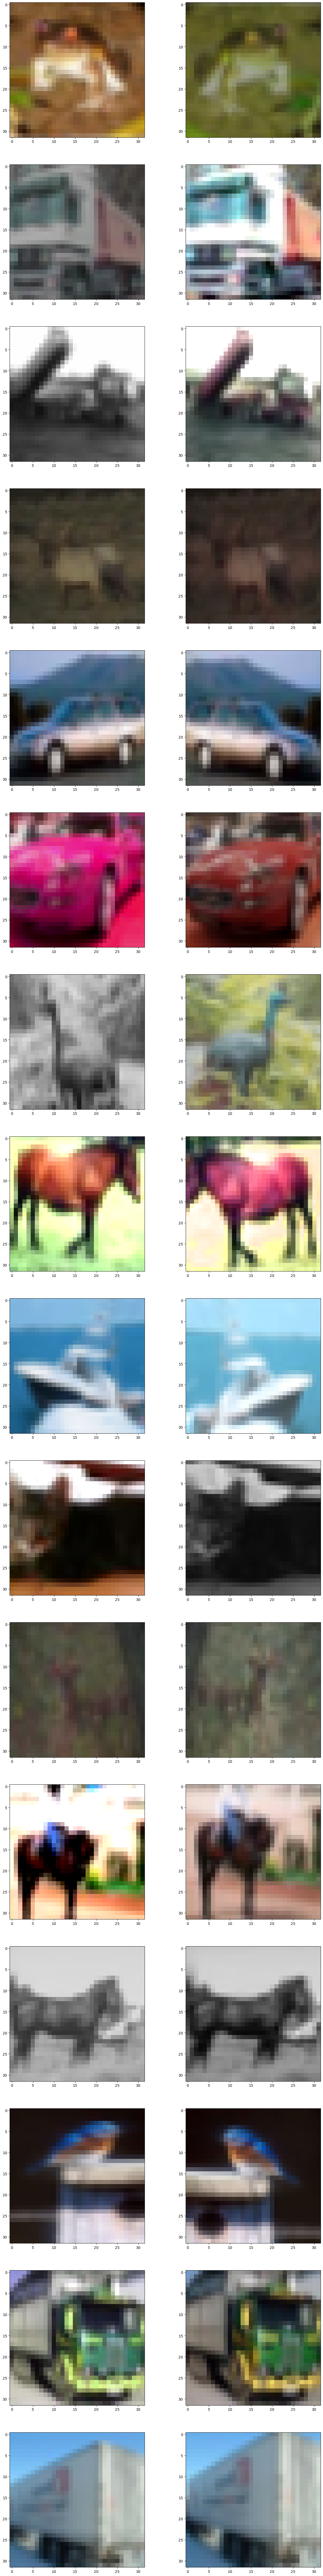

In [217]:
#MEAN = np.array([0.485, 0.456, 0.406]).reshape((1,1,3))
#STD = np.array([0.229, 0.224, 0.25]).reshape((1,1,3))
fig,axs = plt.subplots(16,2,figsize=(16,128))
row = 0
col = 0
for step,(x1,x2) in enumerate(dl):
    # change shape
    for i in range(16):
        #print(x1[i]*STD + MEAN)
        #print(x2[i]*STD + MEAN)
        axs[i,0].imshow((x1[i]*STD + MEAN).squeeze().permute(1,2,0).numpy())
        axs[i,1].imshow((x2[i]*STD + MEAN).squeeze().permute(1,2,0).numpy())
    break

In [218]:
# define the model where there is a resnet18 backbone and a linear head
class C10Model(nn.Module):
    def __init__(self):
        super(C10Model,self).__init__()
        self.pretrained = models.resnet18(pretrained=True)
        # self.pretrained.conv1 = nn.Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), bias=False)
        
        self.encoder = nn.Sequential(
            nn.Linear(1000,512),
            nn.ReLU(),
            nn.Linear(512,512),
        )
        
    def forward(self,x):
        out = self.pretrained(x)
        out = self.encoder(torch.squeeze(out))
        return out

In [219]:
model = C10Model()
model.to(device)

e:\Anaconda\envs\snk\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
e:\Anaconda\envs\snk\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


C10Model(
  (pretrained): ResNet(
    (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (1): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track

In [220]:
x = np.random.random((32,3,224,224))
print(x.shape)

(32, 3, 224, 224)


In [221]:
out = model(torch.tensor(x, device = device, dtype = torch.float32))

In [222]:
out[0].shape, out[1].shape

(torch.Size([512]), torch.Size([512]))

In [223]:
def load_optimizer(arg_optimizer, model, batch_size):

    scheduler = None
    if arg_optimizer == "Adam":
        optimizer = torch.optim.Adam(model.parameters(), lr=3e-4)  # TODO: LARS
    elif arg_optimizer == "Adam":
        # optimized using LARS with linear learning rate scaling
        # (i.e. LearningRate = 0.3 × BatchSize/256) and weight decay of 10−6.
        learning_rate = 0.3 * batch_size / 256
        optimizer = optim.Adam(
            
        )

        # "decay the learning rate with the cosine decay schedule without restarts"
        scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(
            optimizer, epochs, eta_min=0, last_epoch=-1
        )
    else:
        raise NotImplementedError

    return optimizer, scheduler

def save_model(model, optimizer, scheduler, current_epoch, name):
    out = os.path.join('saved_models/',name.format(current_epoch))

    torch.save({'model_state_dict': model.state_dict(),
                'optimizer_state_dict': optimizer.state_dict(),
                'scheduler_state_dict':scheduler.state_dict()}, out)

In [224]:
!mkdir saved_models

A subdirectory or file saved_models already exists.


In [225]:
class SimCLR_Loss(nn.Module):
    def __init__(self, batch_size, temperature):
        super().__init__()
        self.batch_size = batch_size
        self.temperature = temperature

        self.mask = self.mask_correlated_samples(batch_size)
        self.criterion = nn.CrossEntropyLoss(reduction="sum")
        self.similarity_f = nn.CosineSimilarity(dim=2)
        
        self.tot_neg = 0

    def mask_correlated_samples(self, batch_size):
        N = 2 * batch_size
        mask = torch.ones((N, N), dtype=bool)
        mask = mask.fill_diagonal_(0)
        
        for i in range(batch_size):
            mask[i, batch_size + i] = 0
            mask[batch_size + i, i] = 0
            
        return mask

    def forward(self, z_i, z_j):
        """
        We do not sample negative examples explicitly.
        Instead, given a positive pair, similar to (Chen et al., 2017), we treat the other 2(N − 1) augmented examples within a minibatch as negative examples.
        """
        N = 2 * self.batch_size #* self.world_size
        
        #z_i_ = z_i / torch.sqrt(torch.sum(torch.square(z_i),dim = 1, keepdim = True))
        #z_j_ = z_j / torch.sqrt(torch.sum(torch.square(z_j),dim = 1, keepdim = True))

        z = torch.cat((z_i, z_j), dim=0)

        sim = self.similarity_f(z.unsqueeze(1), z.unsqueeze(0)) / self.temperature
        
        #print(sim.shape)

        sim_i_j = torch.diag(sim, self.batch_size)
        sim_j_i = torch.diag(sim, -self.batch_size)
        
        
        # We have 2N samples, but with Distributed training every GPU gets N examples too, resulting in: 2xNxN
        positive_samples = torch.cat((sim_i_j, sim_j_i), dim=0).reshape(N, 1)
        negative_samples = sim[self.mask].reshape(N, -1)
        
        
        #SIMCLR
        labels = torch.from_numpy(np.array([0]*N)).reshape(-1).to(positive_samples.device).long() #.float()
        #labels was torch.zeros(N)
        logits = torch.cat((positive_samples, negative_samples), dim=1)
        loss = self.criterion(logits, labels)
        loss /= N
        
        return loss

In [226]:
optimizer = optim.Adam([params for params in model.parameters() if params.requires_grad], lr=0.2, weight_decay=1e-6)

# "decay the learning rate with the cosine decay schedule without restarts"
warmupscheduler = torch.optim.lr_scheduler.LambdaLR(optimizer, lambda epoch : (epoch+1)/10.0, verbose = True)
mainscheduler = torch.optim.lr_scheduler.CosineAnnealingWarmRestarts(optimizer, 500, eta_min=0.05, last_epoch=-1, verbose = True)

Adjusting learning rate of group 0 to 2.0000e-02.
Epoch 00000: adjusting learning rate of group 0 to 2.0000e-01.


In [227]:
criterion = SimCLR_Loss(batch_size = 128, temperature = 0.5)

In [228]:
trimages = images[:40000]
valimages = images[40000:]
trlabels = labels[:40000]
vallabels = labels[40000:]
print(trimages.shape)
print(valimages.shape)


(40000, 3, 32, 32)
(10000, 3, 32, 32)


In [229]:
dg = C10DataGen('train',trimages)#train_df)
dl = DataLoader(dg,batch_size = 128,drop_last=True)

In [230]:
vdg = C10DataGen('valid',valimages)#_df)
vdl = DataLoader(vdg,batch_size = 128,drop_last=True)

(array([1014., 1014.,  952., 1016.,  997., 1025.,  980.,  977., 1003.,
        1022.]),
 array([0. , 0.9, 1.8, 2.7, 3.6, 4.5, 5.4, 6.3, 7.2, 8.1, 9. ]),
 <BarContainer object of 10 artists>)

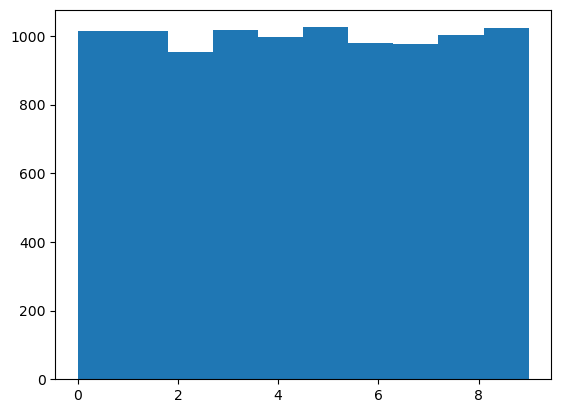

In [231]:
plt.hist(vallabels)

In [241]:
nr = 0
global_step = 0
current_epoch = 0
epochs = 1

In [233]:
def plot_features(model, num_classes, num_feats, batch_size, val_df = None):
    preds = np.array([]).reshape((0,1))
    gt = np.array([]).reshape((0,1))
    feats = np.array([]).reshape((0,num_feats))
    model.eval()
    with torch.no_grad():
        for x1,x2 in vdl:
            x1 = x1.squeeze().to(device = device, dtype = torch.float)#.view((-1,3,224,224))
            #y = y.to(device = 'cuda:0')#.view((-1,1))
            out = model(x1)
            out = out.cpu().data.numpy()#.reshape((1,-1))
            feats = np.append(feats,out,axis = 0)
    
    tsne = TSNE(n_components = 2, perplexity = 50)
    x_feats = tsne.fit_transform(feats)
    #plt.scatter(x_feats[:,1],x_feats[:,0])
    num_samples = int(batch_size*(valimages.shape[0]//batch_size))#(len(val_df)
    
    for i in range(num_classes):
        #plt.scatter(x_feats[val_df['class'].iloc[:num_samples].values==i,1],x_feats[val_df['class'].iloc[:num_samples].values==i,0])
        plt.scatter(x_feats[vallabels[:num_samples]==i,1],x_feats[vallabels[:num_samples]==i,0])
    
    plt.legend([str(i) for i in range(num_classes)])
    plt.show()

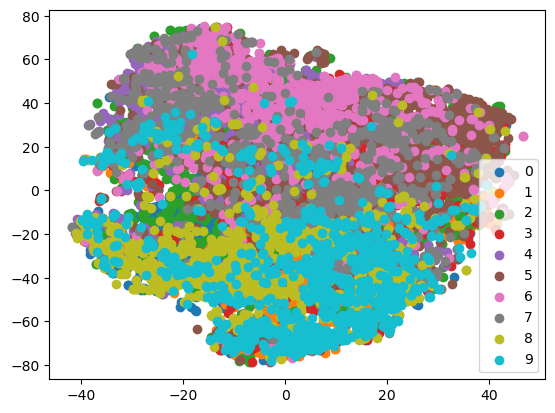

In [234]:
plot_features(model, 10, 512, 128)

In [242]:
def train(train_loader, model, criterion, optimizer):
    loss_epoch = 0
    print('train')
    for step, (x_i, x_j) in enumerate(train_loader):
        optimizer.zero_grad()
        x_i = x_i.squeeze().to(device).float()
        x_j = x_j.squeeze().to(device).float()

        # positive pair, with encoding
        z_i = model(x_i)
        z_j = model(x_j)

        loss = criterion(z_i, z_j)
        loss.backward()

        optimizer.step()
        
        # if nr == 0 and step % 50 == 0:
        print(f"Step [{step}/{len(train_loader)}]\t Loss: {round(loss.item(), 5)}")

        loss_epoch += loss.item()
    return loss_epoch

In [243]:
def valid(valid_loader, model, criterion):
    loss_epoch = 0
    print('valid')
    for step, (x_i, x_j) in enumerate(valid_loader):
        
        x_i = x_i.squeeze().to(device).float()
        x_j = x_j.squeeze().to(device).float()
        
        # positive pair, with encoding
        z_i = model(x_i)
        z_j = model(x_j)

        loss = criterion(z_i, z_j)
        
        print(f"Step [{step}/{len(valid_loader)}]\t Loss: {round(loss.item(),5)}")

        loss_epoch += loss.item()
    return loss_epoch

In [245]:
tr_loss = []
val_loss = []

In [246]:
combined_time = time.time()
for epoch in range(epochs):
        
    print(f"Epoch [{epoch}/{epochs}]\t")
    stime = time.time()

    model.train()
    tr_loss_epoch = train(dl, model, criterion, optimizer)

    if nr == 0 and epoch < 10:
        warmupscheduler.step()
    if nr == 0 and epoch >= 10:
        mainscheduler.step()
    
    lr = optimizer.param_groups[0]["lr"]

    if nr == 0 and (epoch+1) % 50 == 0:
        save_model(model, optimizer, mainscheduler, current_epoch,"SimCLR_CIFAR10_RN50_P128_LR0P2_LWup10_Cos500_T0p5_B128_checkpoint_{}_260621.pt")

    model.eval()
    with torch.no_grad():
        val_loss_epoch = valid(vdl, model, criterion)

    if nr == 0:
        
        tr_loss.append(tr_loss_epoch / len(dl))
        
        val_loss.append(val_loss_epoch / len(vdl))
        
        print(
            f"Epoch [{epoch}/{epochs}]\t Training Loss: {tr_loss_epoch / len(dl)}\t lr: {round(lr, 5)}"
        )
        print(
            f"Epoch [{epoch}/{epochs}]\t Validation Loss: {val_loss_epoch / len(vdl)}\t lr: {round(lr, 5)}"
        )
        current_epoch += 1

    dg.on_epoch_end()

    time_taken = (time.time()-stime)/60
    print(f"Epoch [{epoch}/{epochs}]\t Time Taken: {time_taken} minutes")

    if (epoch+1)%10==0:
        plot_features(model.backbone, 10, 512, 128) #, valimages)

## end training
print(f"Total Time Taken: {(time.time()-combined_time)/60} minutes")
save_model(model, optimizer, mainscheduler, current_epoch, "SimCLR_CIFAR10_RN50_P128_LR0P2_LWup10_Cos500_T0p5_B128_checkpoint_{}_260621.pt")

Epoch [0/1]	
train


e:\Anaconda\envs\snk\lib\site-packages\torchvision\transforms\functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(


Step [0/312]	 Loss: 5.23535
Step [1/312]	 Loss: 5.54094
Step [2/312]	 Loss: 5.54072
Step [3/312]	 Loss: 5.54027
Step [4/312]	 Loss: 5.53974
Step [5/312]	 Loss: 5.53966
Step [6/312]	 Loss: 5.5387
Step [7/312]	 Loss: 5.53822
Step [8/312]	 Loss: 5.53654
Step [9/312]	 Loss: 5.53503
Step [10/312]	 Loss: 5.53336
Step [11/312]	 Loss: 5.52942
Step [12/312]	 Loss: 5.52422
Step [13/312]	 Loss: 5.51693
Step [14/312]	 Loss: 5.50479
Step [15/312]	 Loss: 5.4783
Step [16/312]	 Loss: 5.45642
Step [17/312]	 Loss: 5.39702
Step [18/312]	 Loss: 5.36406
Step [19/312]	 Loss: 5.34829
Step [20/312]	 Loss: 5.30767
Step [21/312]	 Loss: 5.36855
Step [22/312]	 Loss: 5.22579
Step [23/312]	 Loss: 5.17941
Step [24/312]	 Loss: 5.1773
Step [25/312]	 Loss: 5.1452
Step [26/312]	 Loss: 5.14213
Step [27/312]	 Loss: 5.13449
Step [28/312]	 Loss: 5.23717
Step [29/312]	 Loss: 5.23327
Step [30/312]	 Loss: 5.11297
Step [31/312]	 Loss: 5.10127
Step [32/312]	 Loss: 5.13834
Step [33/312]	 Loss: 5.07589
Step [34/312]	 Loss: 5.012
S

In [247]:
np.unique(vallabels)

array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9])

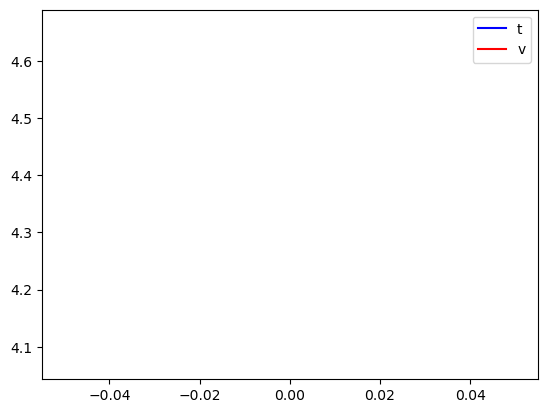

In [248]:
plt.plot(tr_loss,'b-')
plt.plot(val_loss,'r-')
plt.legend(['t','v'])
plt.show()

In [ ]:
def test():
    